# Importing Necessary Libraries

In [104]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, mixed_precision
from sklearn.metrics import classification_report, confusion_matrix

# Defining Model Architecture (VGG19) and Data Loading

In [23]:
def cnn(input_shape, num_classes):

    base = VGG19(weights = "imagenet", include_top = False, input_shape = input_shape)
    base.trainable = False
    
    model = tf.keras.Sequential([
        base,
        # layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        
        layers.Dense(512, activation = "relu"),
        layers.BatchNormalization(),
        
        layers.Dense(256, activation = "relu"),
        layers.BatchNormalization(),

        layers.Dense(128, activation = "relu"),
        layers.BatchNormalization(),

        layers.Dense(num_classes, activation = "softmax")
    ])

    return model

In [106]:
dir = "../Dataset/Intel/seg_train"

batch_size = 16
img_h, img_w = 150, 150

train_dataset = tf.keras.utils.image_dataset_from_directory(dir, seed = 100, image_size = (img_h, img_w), batch_size = batch_size, shuffle = True)

Found 14034 files belonging to 6 classes.


In [11]:
train_dataset.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Training

In [25]:
model = cnn(input_shape = (150, 150, 3), num_classes = 6)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               4194816   
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                      

In [29]:
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [31]:
# Ensure GPU Usage (if you want to use CPU, "/CPU:0")
with tf.device("/GPU:0"):
    history = model.fit(train_dataset, epochs = 20)

Epoch 1/20
878/878 [==============================] - 116s 125ms/step - loss: 0.4186 - accuracy: 0.8511
Epoch 2/20
878/878 [==============================] - 94s 107ms/step - loss: 0.2434 - accuracy: 0.9139
Epoch 3/20
878/878 [==============================] - 98s 111ms/step - loss: 0.1806 - accuracy: 0.9344
Epoch 4/20
878/878 [==============================] - 94s 107ms/step - loss: 0.1376 - accuracy: 0.9510
Epoch 5/20
878/878 [==============================] - 67s 77ms/step - loss: 0.1153 - accuracy: 0.9577
Epoch 6/20
878/878 [==============================] - 68s 77ms/step - loss: 0.0973 - accuracy: 0.9642
Epoch 7/20
878/878 [==============================] - 68s 77ms/step - loss: 0.0766 - accuracy: 0.9720
Epoch 8/20
878/878 [==============================] - 68s 78ms/step - loss: 0.0631 - accuracy: 0.9785
Epoch 9/20
878/878 [==============================] - 68s 78ms/step - loss: 0.0555 - accuracy: 0.9803
Epoch 10/20
878/878 [==============================] - 70s 79ms/step - loss: 

# Saving The Trained Model

In [179]:
model.save("../Models/Intel/Model With Transfer Learning.h5")

# Model Evaluation and Other Metrics

## Loss and Accuracy Graphs

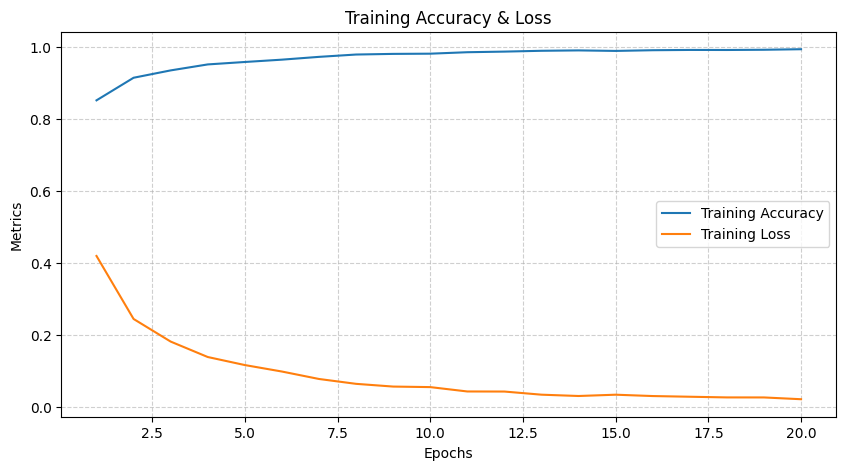

In [108]:
# Plot training accuracy and loss
def plot_loss_accuracy(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 5))  # Adjust size

    # Plot accuracy and loss on the same graph
    plt.plot(epochs, acc, label='Training Accuracy')  # Blue line with circles
    plt.plot(epochs, loss, label='Training Loss')  # Red line with triangles
    
    # Labels & title
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Training Accuracy & Loss')
    
    # Grid and legend
    plt.grid(True, linestyle='--', alpha=0.6)  # Dashed gridlines
    plt.legend()

    plt.show()

plot_loss_accuracy(history)

## Confusion Matrix and Classification Report

In [100]:
dir = "../Dataset/Intel/seg_test"

batch_size = 16
img_h, img_w = 150, 150

test_dataset = tf.keras.utils.image_dataset_from_directory(dir, seed = 100, image_size = (img_h, img_w), batch_size = batch_size, shuffle = False)

Found 3000 files belonging to 6 classes.


188/188 [==============================] - 8s 41ms/step
📊 Classification Report:

              precision    recall  f1-score   support

   buildings       0.92      0.89      0.91       437
      forest       0.96      0.99      0.98       474
     glacier       0.83      0.80      0.82       553
    mountain       0.82      0.83      0.82       525
         sea       0.93      0.91      0.92       510
      street       0.89      0.93      0.91       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



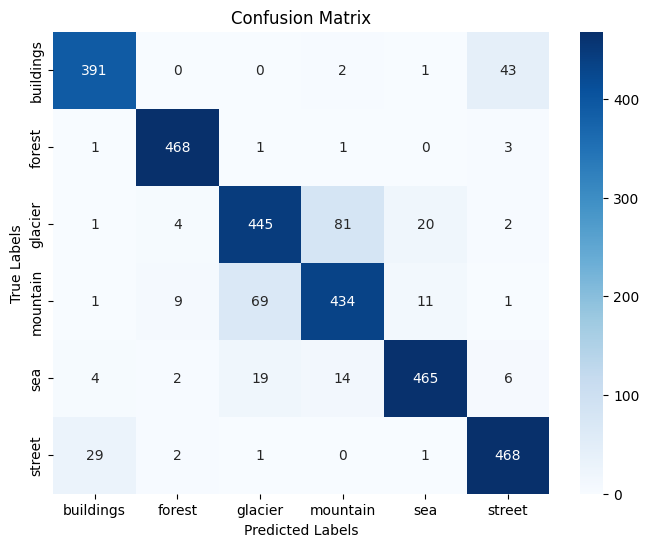

In [110]:
y_true = np.concatenate([labels.numpy() for _, labels in test_dataset])

# Get model predictions
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Define class names
class_names = test_dataset.class_names

# Generate Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Inference

## Importing the necessary libraries

In [135]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import random
import math

In [113]:
model = load_model("../Models/Intel/Model With Transfer Learning.h5")

In [149]:
def inference_grid(img_paths, grid_cols=3):
    class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
    
    num_images = len(img_paths)
    grid_rows = math.ceil(num_images / grid_cols)  # Calculate number of rows needed

    plt.figure(figsize=(grid_cols * 4, grid_rows * 4))  # Adjust figure size dynamically

    for i, img_path in enumerate(img_paths):
        img = cv2.imread(img_path)

        # Preprocess image
        img_expanded = np.expand_dims(img, axis=0)

        prediction = model.predict(img_expanded)
        predicted_class = np.argmax(prediction, axis=1)[0]
        predicted_label = class_names[predicted_class]

        # Plot image in a grid
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{predicted_label}", fontsize=12)

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

1/1 [==============================] - 0s 18ms/step


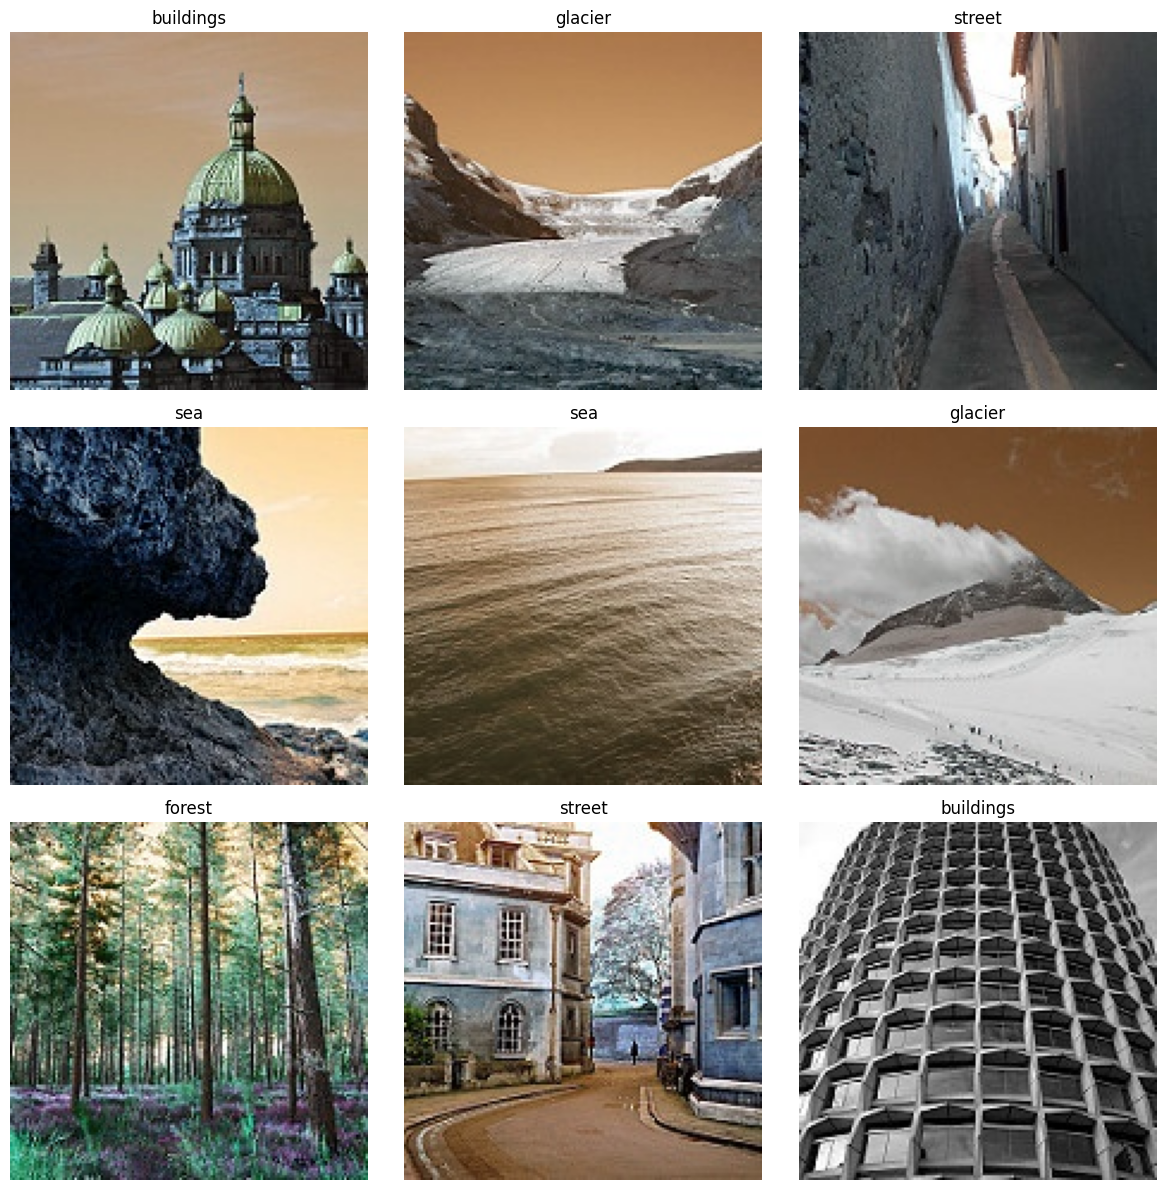

In [174]:
parent_dir = "../Dataset/Intel/seg_pred/"

num_images = 9  # Number of images to predict

img_files = random.sample(os.listdir(parent_dir), num_images)
img_paths = [os.path.join(parent_dir, img) for img in img_files]

inference_grid(img_paths, grid_cols = 3)